In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
    datasets,
)
import pickle
from matplotlib.ticker import MaxNLocator
import tensorflow.keras.backend as K
import tensorboard as tb
from model import GAN
import librosa as lb
from preprocess import load_raw_audio, bandpass_filter
from preprocess import denormalise
from IPython.lib.display import Audio
import IPython
import pandas as pd
import json
import seaborn as sns
import scipy.signal
from scipy.fft import fft
from scipy.signal import spectrogram
from utils import *
from keras.utils.vis_utils import plot_model
from sklearn.neighbors import KernelDensity

In [9]:
def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)

model_directory ="C:/Users/Jayde/Desktop/wavegan/sctf1.1"
#model_directory = newest("C:/Users/Jayde/Desktop/wavegan/")
print(model_directory)
spec_path = f"{model_directory}/model_specifications.json"
with open(spec_path, 'r') as f:
  specs = json.load(f)

C:/Users/Jayde/Desktop/wavegan/sctf1.1


In [10]:
gan = GAN(
    latent_dim = specs["Latent Dim"],
    discriminator_steps= specs["Discriminator Steps"],
    gp_weight= specs["GP Weight"],
    n_categories= specs["N Categories"],
    slice_len=16384,
)

In [ ]:
tf.keras.backend.random_bernoulli([5,5],0.5)

In [11]:
generator = gan.generator
generator.load_weights(f"{model_directory}/generator")

In [39]:
ep="10000"
df = pd.read_csv(f"{model_directory}/Bits{ep}.csv")
#print((df.query("bit ==0 and dose ==0")["f0"]))
#df["f0_ate"] = df["f0"] - (df.query("bit ==0 and dose ==0")["f0"])[10]

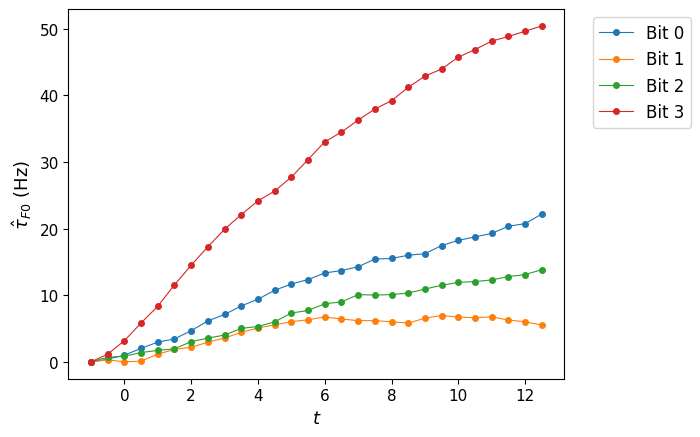

In [7]:
for bit in range(specs["N Categories"]):
    bit_data = df.loc[df['bit'] ==bit]
    plt.plot(bit_data['dose'], bit_data['F0_avg'], '-o', markersize = 4,linewidth =0.8, label = f"Bit {bit}")
    #plt.errorbar(bit_data['dose'], bit_data['f0'], yerr=bit_data['f0 std dev'], marker = 'o',markersize = 4,linewidth =0.8, label = f"Bit {bit}")
plt.xlabel(r"$t$", fontsize = 13)
plt.ylabel(r"$\hat{\tau}_{F0}$ (Hz)", fontsize = 13)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize =12)
#plt.legend(fontsize =12)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
#plt.ylim(0,3000)
#plt.ylim([-20,50])
plt.savefig(f"{model_directory}/F0_bits_e_{ep}.png", dpi= 300, bbox_inches = "tight", transparent = True)
plt.show()

C:\Users\Jayde\AppData\Local\Temp\ipykernel_15188\1701317596.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(melted_data.pivot('variable','dose', 'value'),yticklabels = ["AL", "IO", "MU", "TH"],cmap="Blues", cbar_kws={'label': 'Fraction'})


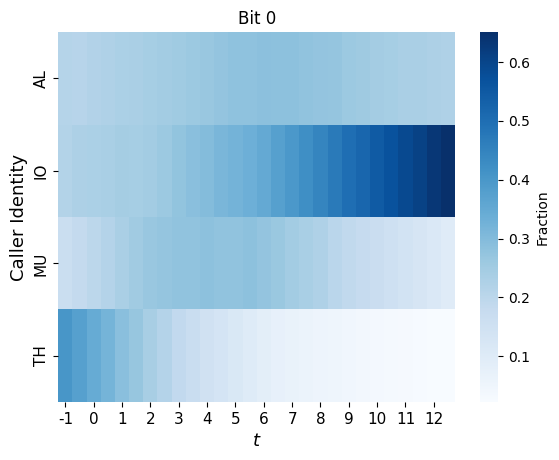

C:\Users\Jayde\AppData\Local\Temp\ipykernel_15188\1701317596.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(melted_data.pivot('variable','dose', 'value'),yticklabels = ["AL", "IO", "MU", "TH"],cmap="Blues", cbar_kws={'label': 'Fraction'})


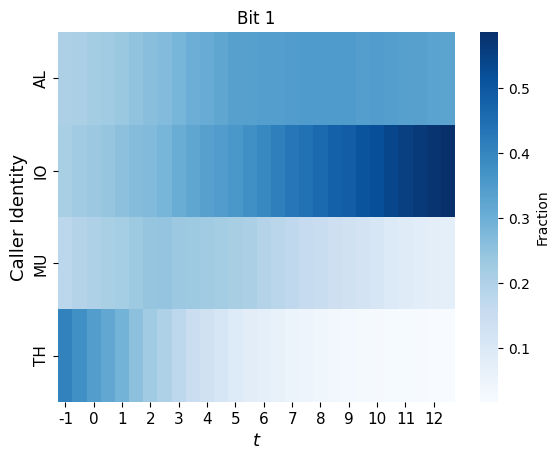

C:\Users\Jayde\AppData\Local\Temp\ipykernel_15188\1701317596.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(melted_data.pivot('variable','dose', 'value'),yticklabels = ["AL", "IO", "MU", "TH"],cmap="Blues", cbar_kws={'label': 'Fraction'})


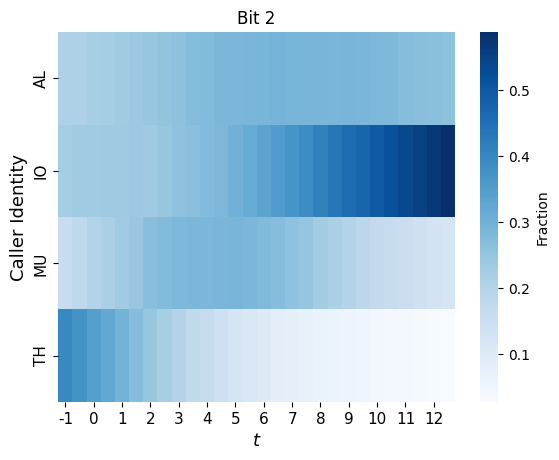

C:\Users\Jayde\AppData\Local\Temp\ipykernel_15188\1701317596.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(melted_data.pivot('variable','dose', 'value'),yticklabels = ["AL", "IO", "MU", "TH"],cmap="Blues", cbar_kws={'label': 'Fraction'})


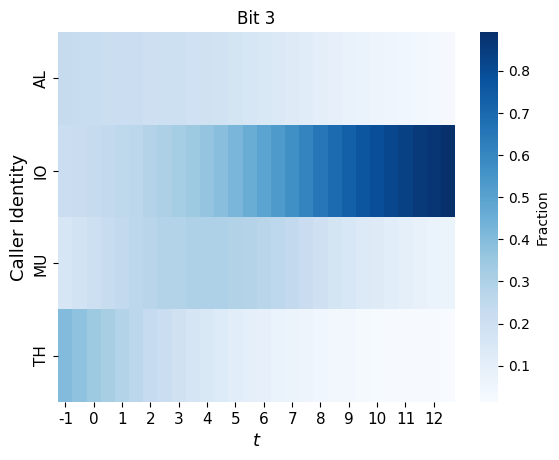

In [51]:
for bit in range(specs["N Categories"]):
    bit_data = df.loc[df['bit'] ==bit]
    y=[]
    x= bit_data['dose']
    for cls in range(4):
        y.append(bit_data[f'cls_{cls}'])
    #plt.stackplot(x,y, labels=['AL','IO','MU','TH'])
    selected_columns = ['dose', 'cls_0', 'cls_1', 'cls_2', 'cls_3']

    # Create a new DataFrame with only the selected columns
    selected_data = bit_data[selected_columns]
    #selected_data.rename({'cls_0':'AL',"cls_1":"IO","cls_2":"MU", "cls_3":"TH"})
    #selected_data.pivot(index="dose", columns=['cls_0', 'cls_1', 'cls_2', 'cls_3'])

    melted_data = pd.melt(selected_data, id_vars=['dose'], value_vars=['cls_0', 'cls_1', 'cls_2', 'cls_3'])
    sns.heatmap(melted_data.pivot('variable','dose', 'value'),yticklabels = ["AL", "IO", "MU", "TH"],cmap="Blues", cbar_kws={'label': 'Fraction'})
    #sns.heatmap(selected_data, annot=False, cmap='YlGnBu', fmt='g', linewidths=.5, cbar_kws={'label': 'Number of Samples'})
    
    plt.xlabel(r"$t$", fontsize = 13)
    plt.ylabel("Caller Identity", fontsize = 13)
    #plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize =12)
    #plt.legend(fontsize =12)
    plt.xticks(fontsize = 11,ticks = np.arange(0.5,28.5,2),labels= np.arange(-1,13), rotation= 0)
    plt.yticks(fontsize = 11)
    plt.title(f"Bit {bit}")
    #plt.ylim(0,1)
    #plt.xlim([min(x),max(x)])
    #plt.savefig(f"{model_directory}/Classes_e{ep}_bit{bit}.png", dpi= 300, bbox_inches = "tight", transparent = True)
    plt.savefig(f"{model_directory}/Classes_heatmap_{ep}_bit{bit}.png", dpi= 300, bbox_inches = "tight", transparent = True)
    plt.show()

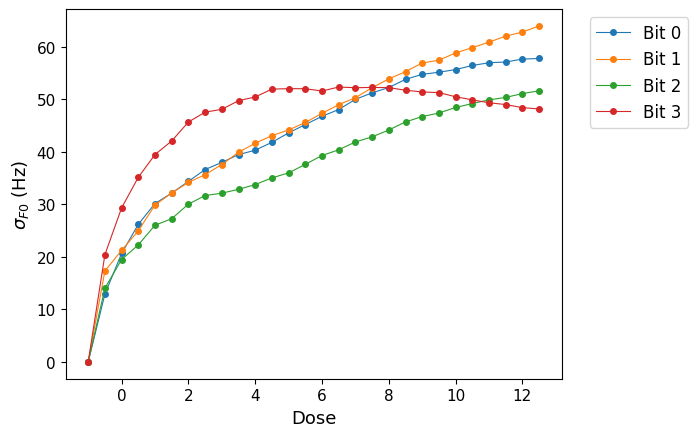

In [9]:
for bit in range(specs["N Categories"]):
    bit_data = df.loc[df['bit'] ==bit]
    plt.plot(bit_data['dose'], bit_data['F0_std'], '-o', markersize = 4,linewidth =0.8, label = f"Bit {bit}")
    #plt.errorbar(bit_data['dose'], bit_data['f0'], yerr=bit_data['f0 std dev'], marker = 'o',markersize = 4,linewidth =0.8, label = f"Bit {bit}")
plt.xlabel("Dose", fontsize = 13)
plt.ylabel("$\sigma_{F0}$ (Hz)", fontsize = 13)
#plt.legend(fontsize = 12)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize =12)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
#plt.savefig("F0_st_dev_bits_e_1400.png", dpi= 1400, bbox_inches = "tight", transparent = True)
#plt.ylim(0,3000)
plt.show()

In [15]:
inputs = create_inputs(specs,20,bit_value= 1, random =True)
outputs=[]
for input in inputs:
    generated_audio = generator.predict(input) 
    audio= np.squeeze(generated_audio)
    #print(generated_audio.shape)
    #audio = denormalise(generated_audio,f"{model_directory}/normaliser_values")
    outputs.append(audio)


1/1 [==============================] - 2s 2s/step


In [16]:
code_1 = outputs[0]
sr = 24414
sr =16000
#code_1,_,_,_,_ = segment_signal(code_1, sr)

for audio in code_1:
    IPython.display.display(Audio(audio, rate =sr))

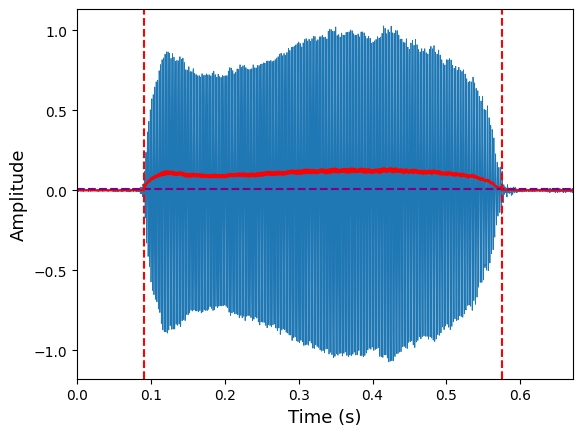

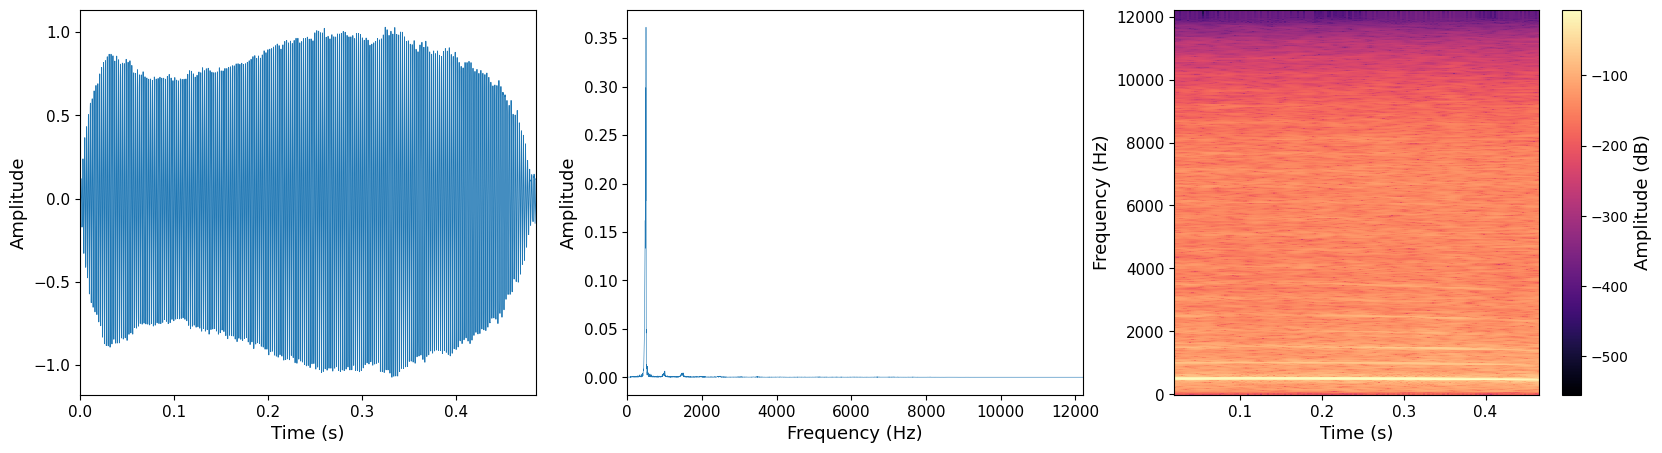

Fundamental Frequency- 503.08386116037497 Hz


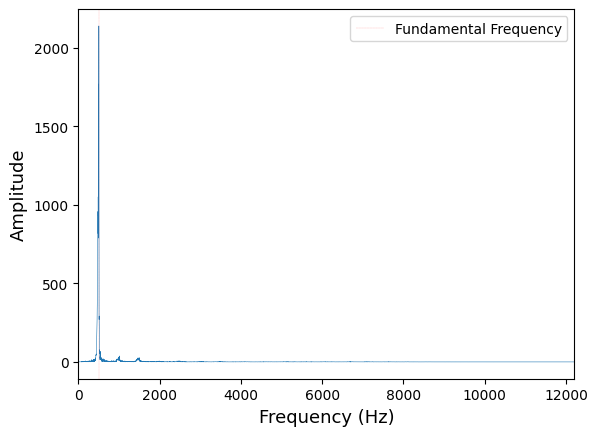

In [22]:
#save_dir = "C:/Users/Jayde/Dropbox/decoding-animimal-communication/figures/nine_graphs.png"
signal =code_1[3]
signal = bandpass_filter(signal,100,8000,sr = sr)
#create_plots(signal, sr, amp_envelope= True, plot_rms= False)
IPython.display.display(Audio(signal, rate =sr))
segmented, start, end, threshold,kde = segment_signal(signal,sr, window_size=20)

fmax = sr/2 #nyquist frequency 
N = len(signal)
delta_t = 1 / sr
times = np.arange(0, N) / sr
signalf = fft(signal)
freqs = np.linspace(0.0, 1.0/(2.0*delta_t), N//2)


plt.plot(times, signal, linewidth=0.6)
#axs[0].librosa.display.waveshow(code_1[1], sr=sr)
plt.xlabel('Time (s)', fontsize= 13)
plt.ylabel('Amplitude', fontsize = 13)

t_rms, rms = RMS_energy(signal,frame_size =32, hop_length=16,sr =sr)
plt.plot(t_rms,kde, color = "r")
plt.xlim(0,max(times))
plt.axhline(threshold,color="purple", linestyle= "dashed")
plt.axvline(times[start], color="r", linestyle= "dashed")
plt.axvline(times[end], color="r", linestyle= "dashed")
plt.show()

fig_dir = f"{model_directory}/generated_10000.png"
create_plots(segmented, sr, amp_envelope= False, plot_rms= False, save_dir=fig_dir )
IPython.display.display(Audio(segmented, rate =sr))
create_fft(segmented,sr)

In [11]:
def segment_signal(signal,sr, window_size=20):
    t,rms= RMS_energy(signal,32,16,sr)

    num_windows = len(rms) // window_size
    background_noise_level = 1000
    for i in range(num_windows):
        start = i * window_size
        end = (i + 1) * window_size
        mean_amplitude = np.mean(rms[start:end])
        background_noise_level = min(background_noise_level,mean_amplitude)

    std = np.std(rms)
    threshold = background_noise_level + 0.2*std
    signal_indexes = np.where(rms >= threshold)[0]
    start,end= signal_indexes[0], signal_indexes[-1]
    timepoints = t[start], t[end]
    start,end = [int(round(i * sr)) for i in timepoints]
    cut_signal = signal[start:end+1]
    return cut_signal, start, end, threshold, rms

In [12]:
def plot_epochs(specs, gan, max_epoch, checkpoints, sr=24414):
    #generate input
    input = create_inputs(specs,5,bit_value= 1, random =True)[0]
    generated = []
    for epoch in range(0,max_epoch+checkpoints,checkpoints):
        print(epoch)
        epoch = "" if epoch == max_epoch else epoch
        generator = gan.generator
        generator.load_weights(f"{model_directory}/generator{str(epoch)}")
        generated_audio = generator.predict(input)[0]
        audio= np.squeeze(generated_audio)
        try:
            audio,_,_,_,_ = segment_signal(audio,sr)
            
        except:
            continue
        create_plots(audio,sr)
        IPython.display.display(Audio(audio, rate =sr))

In [5]:
def plot_epoch_spectrograms(specs, gan, max_epoch, checkpoints, sr= 44100, window_length=1024, save= True):
    input = create_inputs(specs,5,bit_value= 1, random =True)[0]
    generated = []
    epochs =[]
    num_checkpoints = int((max_epoch/checkpoints) +1)
    fig, axs = plt.subplots(num_checkpoints, 5, figsize = (20,5*num_checkpoints))
    for i, epoch in enumerate(range(0,max_epoch+checkpoints,checkpoints)):
        axs[i, 2].set_title(f'EPOCH {epoch}')
        print(epoch)
        epochs.append(epoch)
        epoch = "" if epoch == max_epoch else epoch
        generator = gan.generator
        generator.load_weights(f"{model_directory}/generator{str(epoch)}")
        generated_audio = generator.predict(input)
        audio= np.squeeze(generated_audio)
        #print(generated_audio.shape)
        #audio = denormalise(generated_audio,f"{model_directory}/normaliser_values")
        for j, signal in enumerate(audio):
            #print(signal.shape)
            f_bins, t_bins, Sxx = spectrogram(signal, fs=sr,
                                    window='hann', nperseg=window_length,
                                    noverlap=window_length-64, detrend=False,
                                    scaling='spectrum')
            axs[i, j].pcolormesh(t_bins, f_bins, 20*np.log10(Sxx+1e-100), cmap='magma')
        
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
    
    fig_dir = f"{model_directory}/epoch_spectrograms.png"
    plt.savefig(fig_dir, dpi= 300, bbox_inches = "tight", transparent = True) if save else None
    plt.show()
    

    

In [ ]:
plot_epoch_spectrograms(specs, gan, 1500, 100, sr =44100)

0
1/1 [==============================] - 2s 2s/step


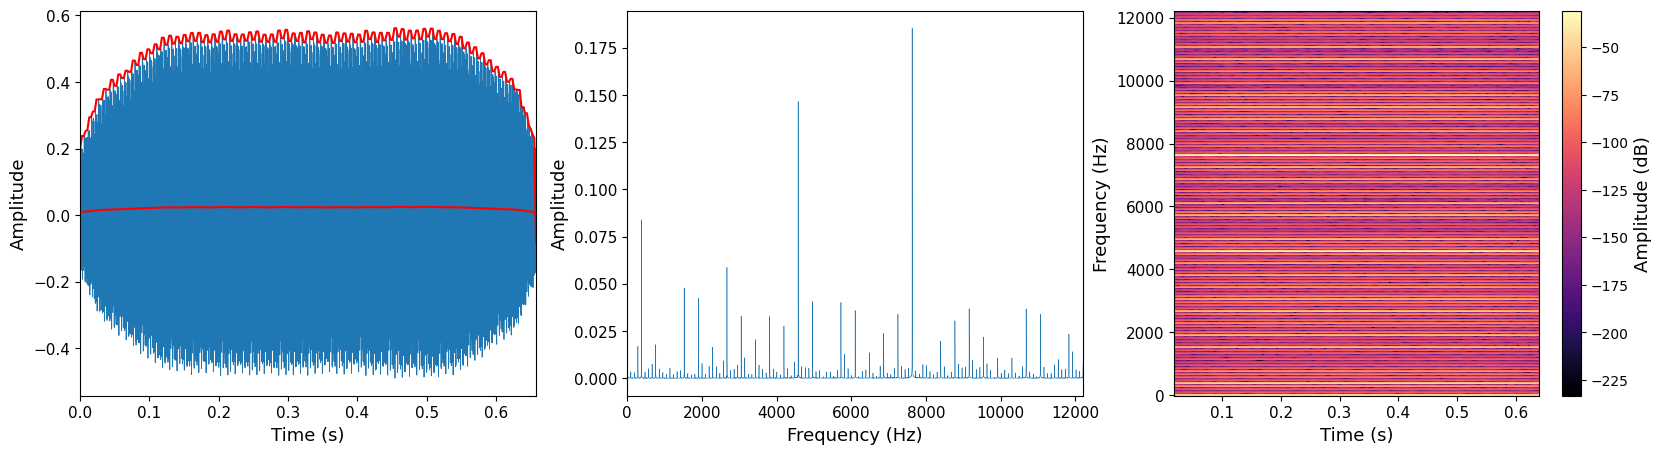

1000
1/1 [==============================] - 0s 355ms/step


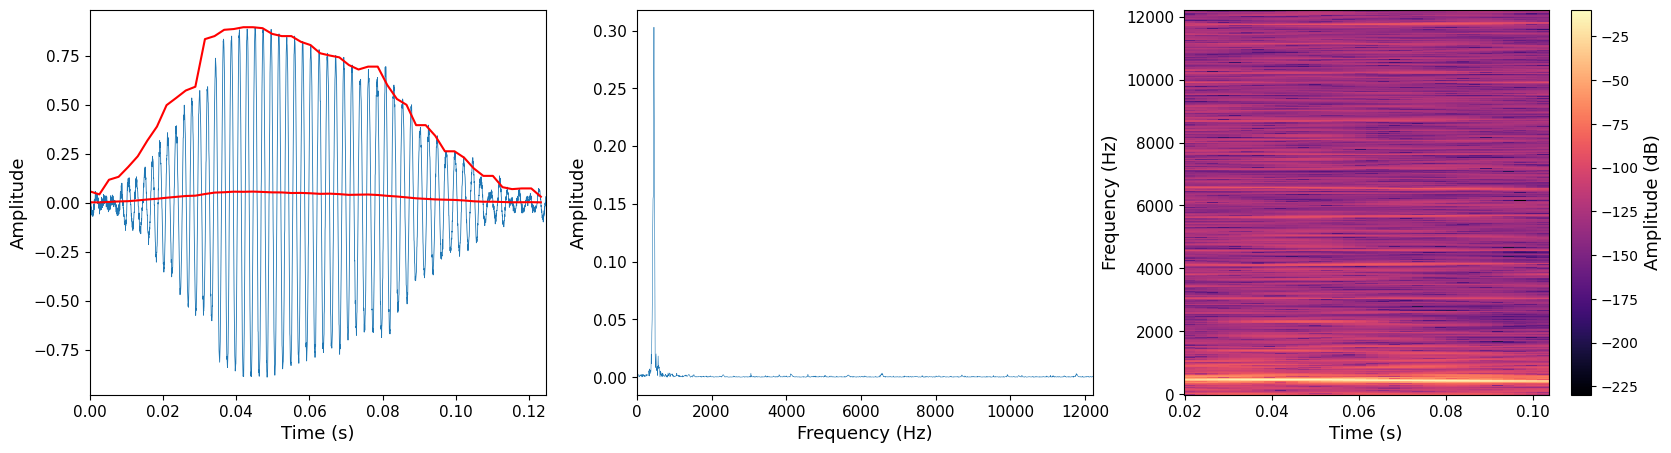

2000
1/1 [==============================] - 0s 359ms/step


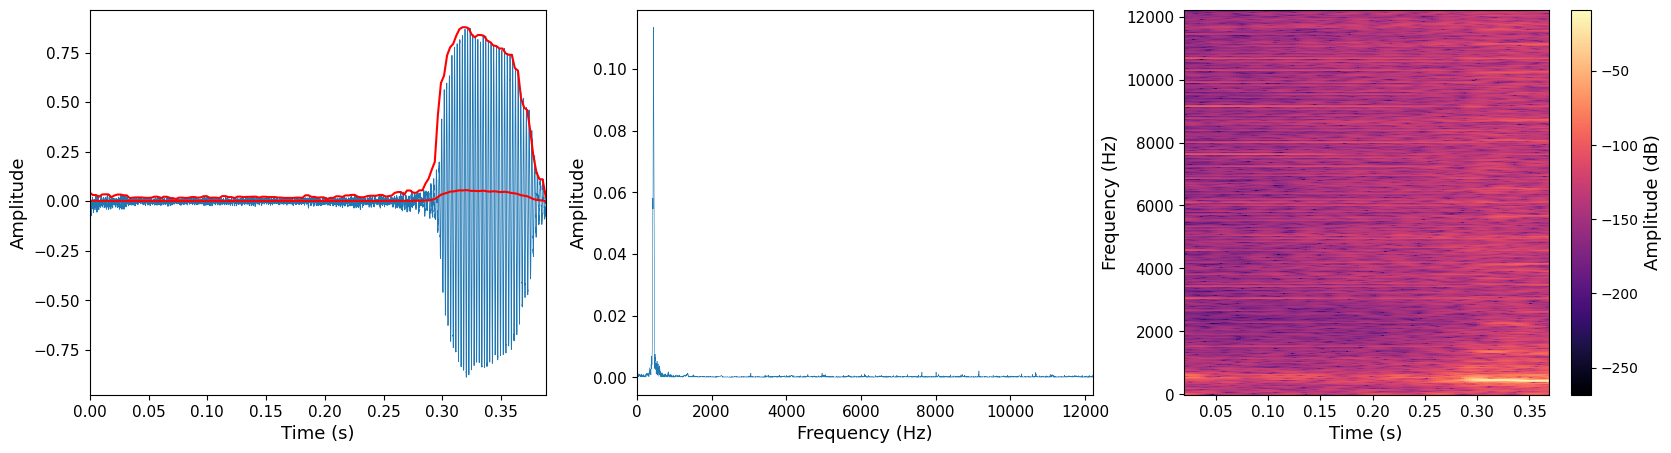

3000
1/1 [==============================] - 0s 347ms/step


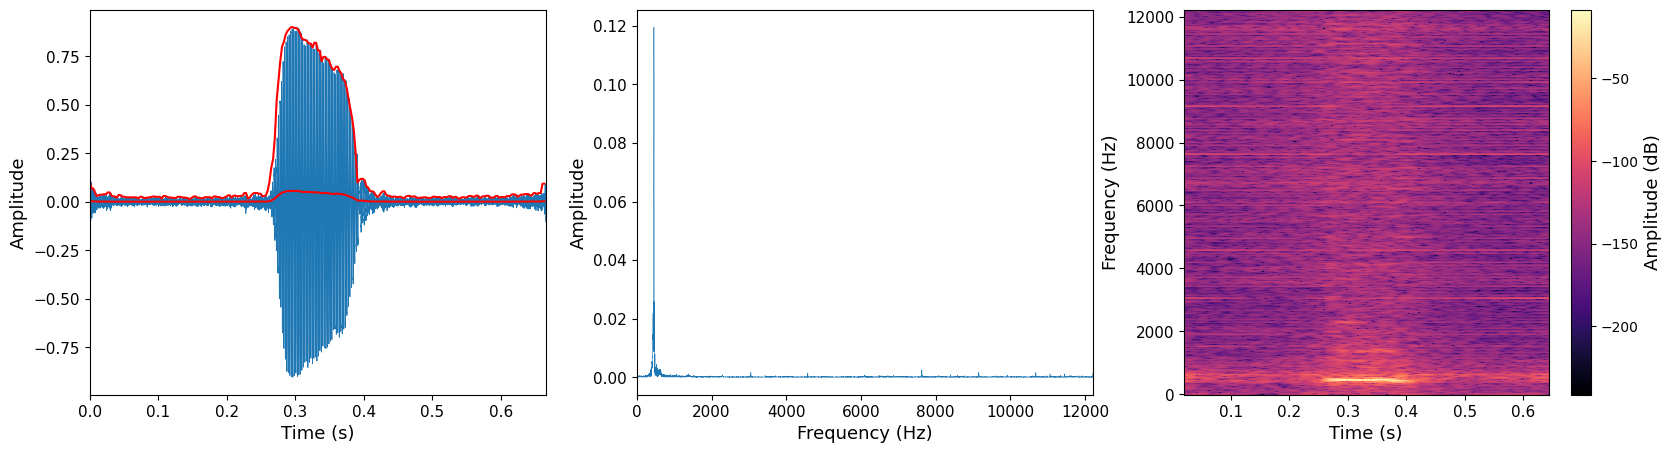

4000
1/1 [==============================] - 0s 341ms/step


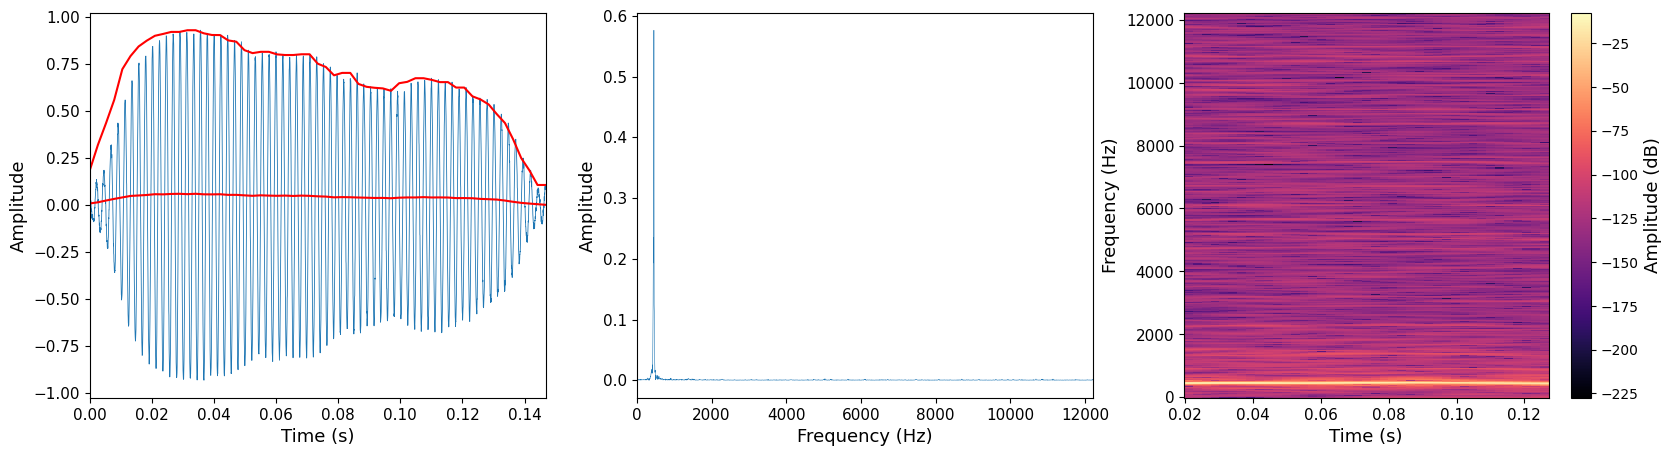

5000
1/1 [==============================] - 0s 293ms/step


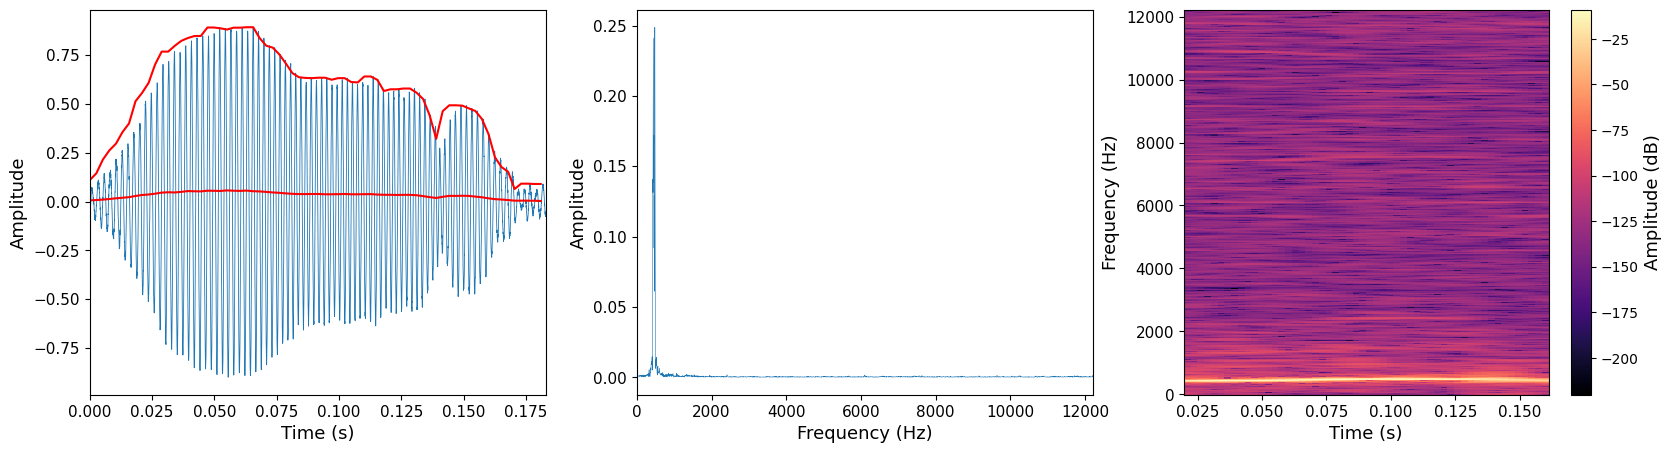

6000
1/1 [==============================] - 0s 414ms/step


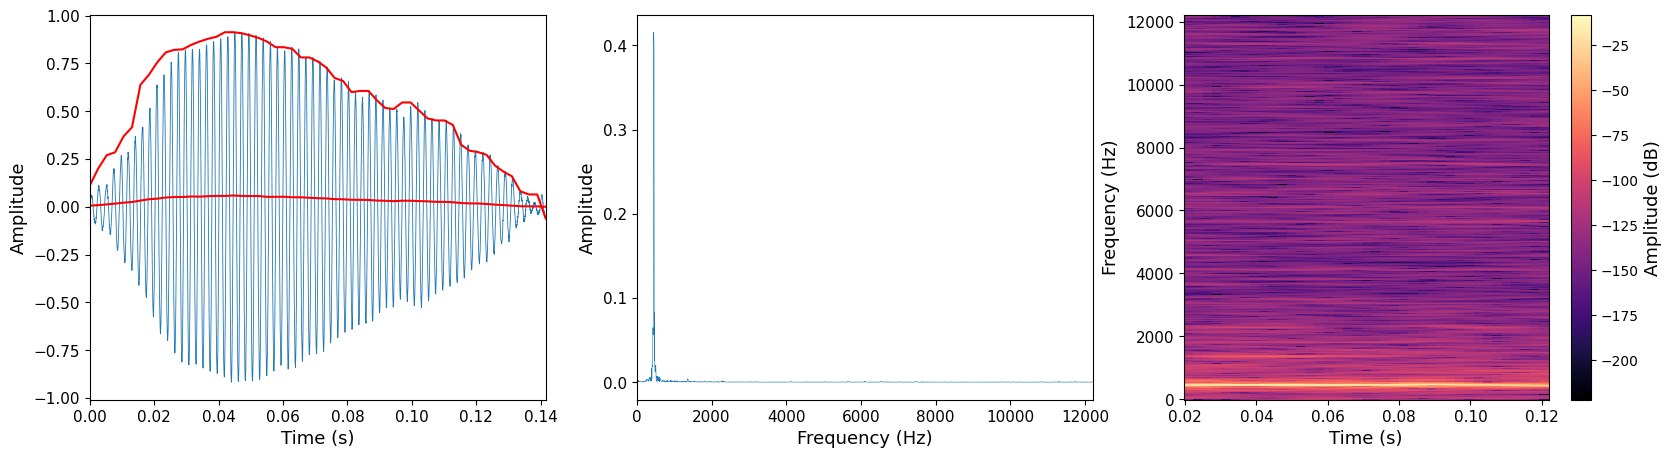

7000
1/1 [==============================] - 1s 656ms/step


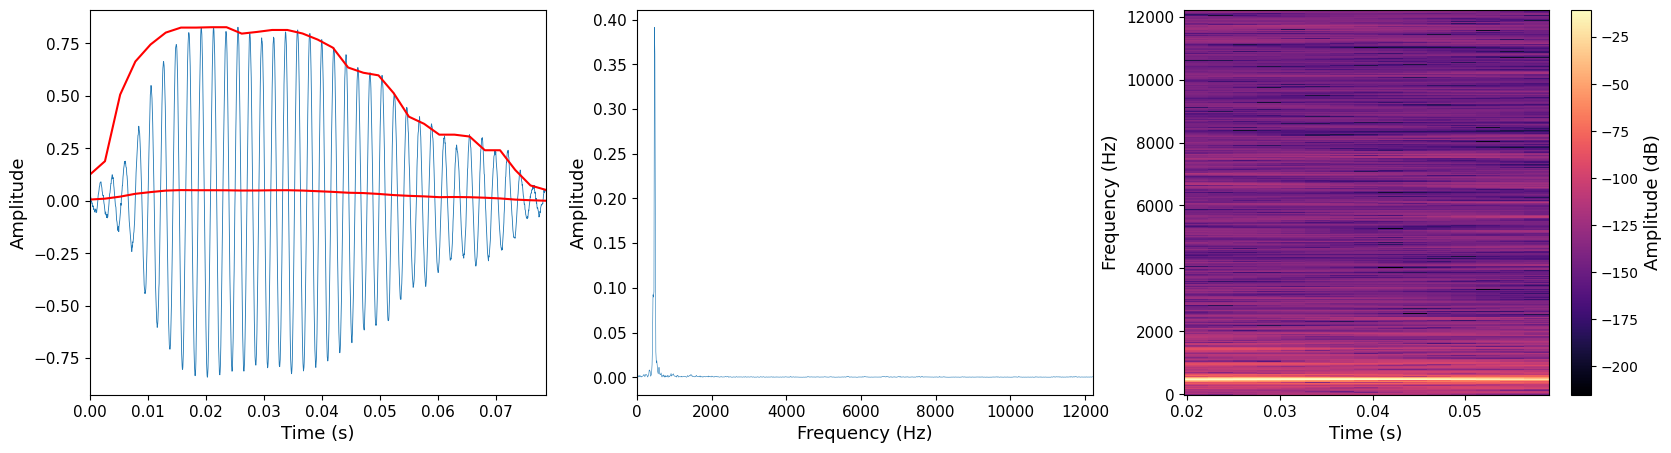

8000
1/1 [==============================] - 0s 381ms/step


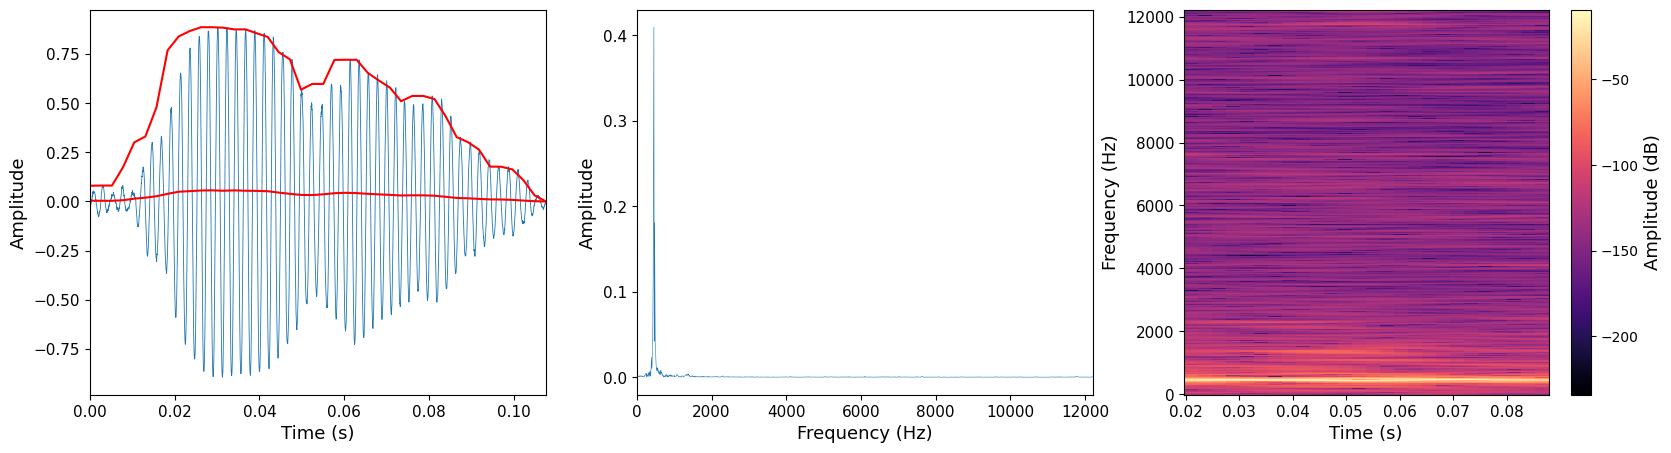

9000
1/1 [==============================] - 0s 371ms/step


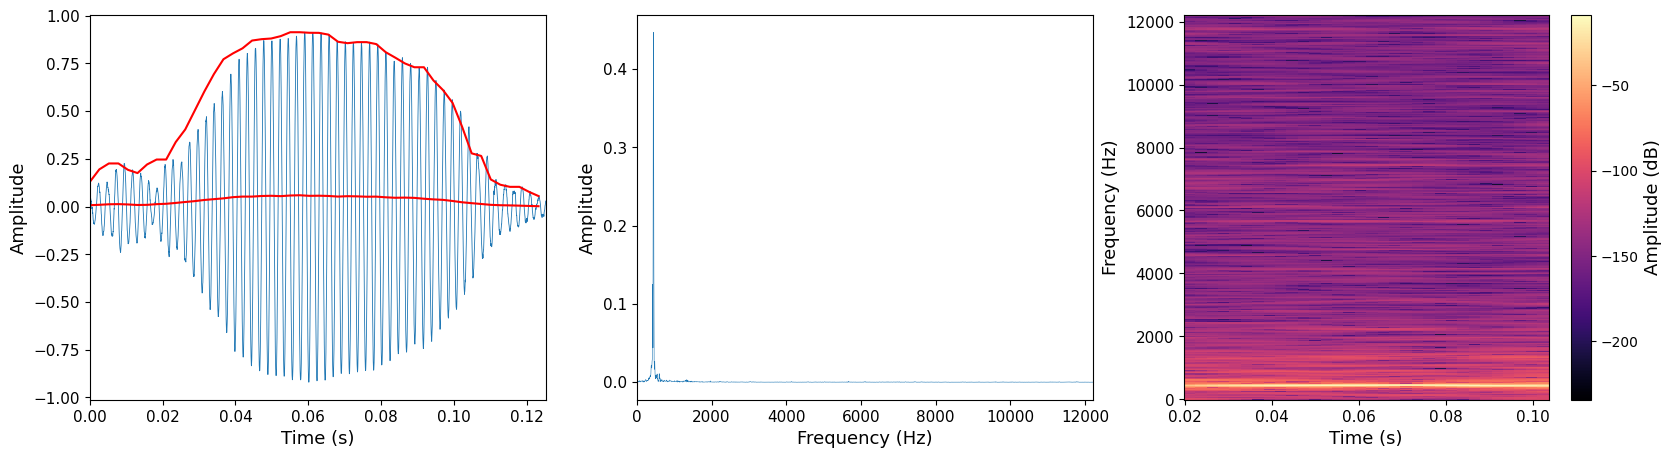

10000
1/1 [==============================] - 0s 385ms/step


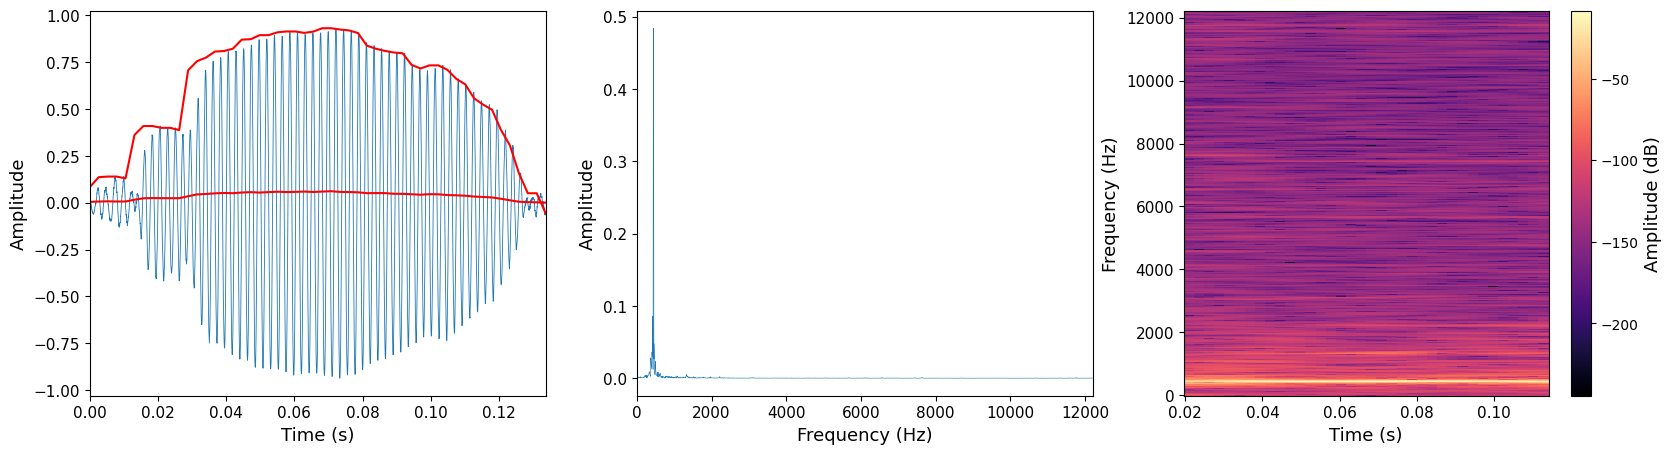

In [13]:
plot_epochs(specs, gan, 10000,1000, sr =24414)

24414


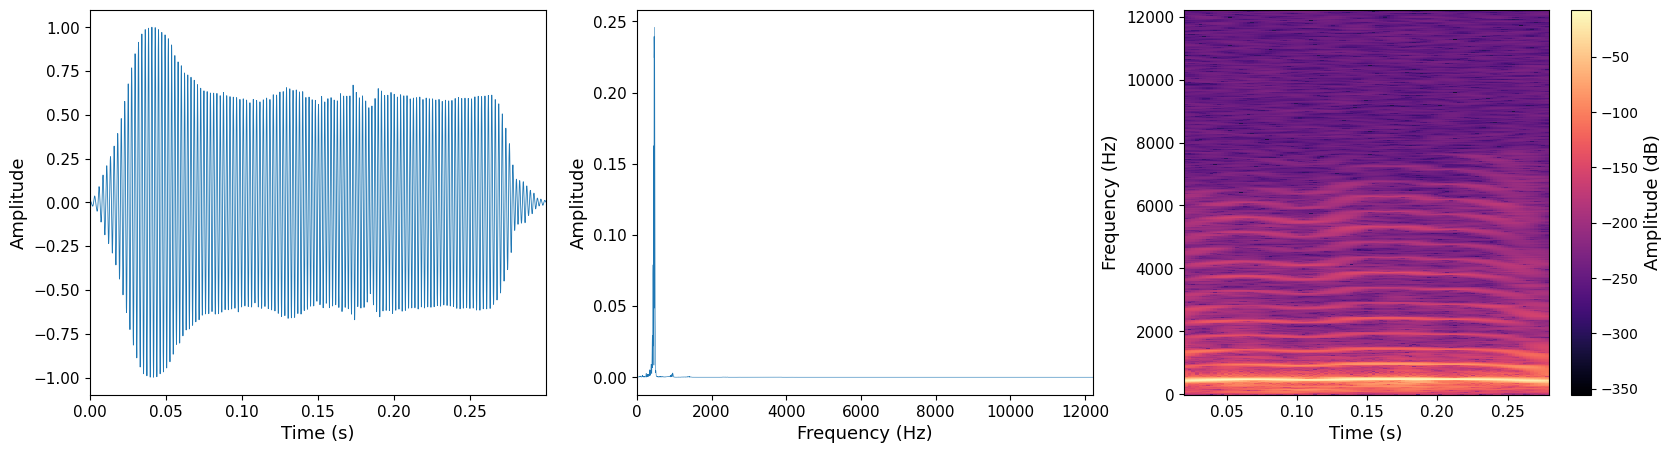

Fundamental Frequency- 477.396690824559 Hz


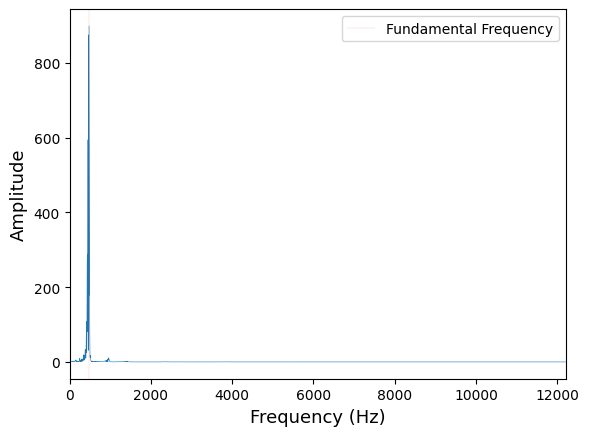

In [23]:
file_path = "C:/Users/Jayde/Desktop/Datasets/sc09/train/Nine_c6ca5d01_nohash_0.wav"
file_path = "C:/Users/Jayde/Desktop/library/macaques/data/train/AL917.wav"
signal, sr = lb.load(file_path, sr = 24414)
print(sr)
IPython.display.display(Audio(signal, rate =sr))
signal /= np.max(np.abs(signal))
create_plots(signal, sr, amp_envelope= False, plot_rms= False, save_dir="macaque_example.png")
create_fft(signal,sr)

c:\Users\Jayde\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 16384 is greater than input length  = 11841, using nperseg = 11841
  warnings.warn('nperseg = {0:d} is greater than input length '


ValueError: noverlap must be less than nperseg.

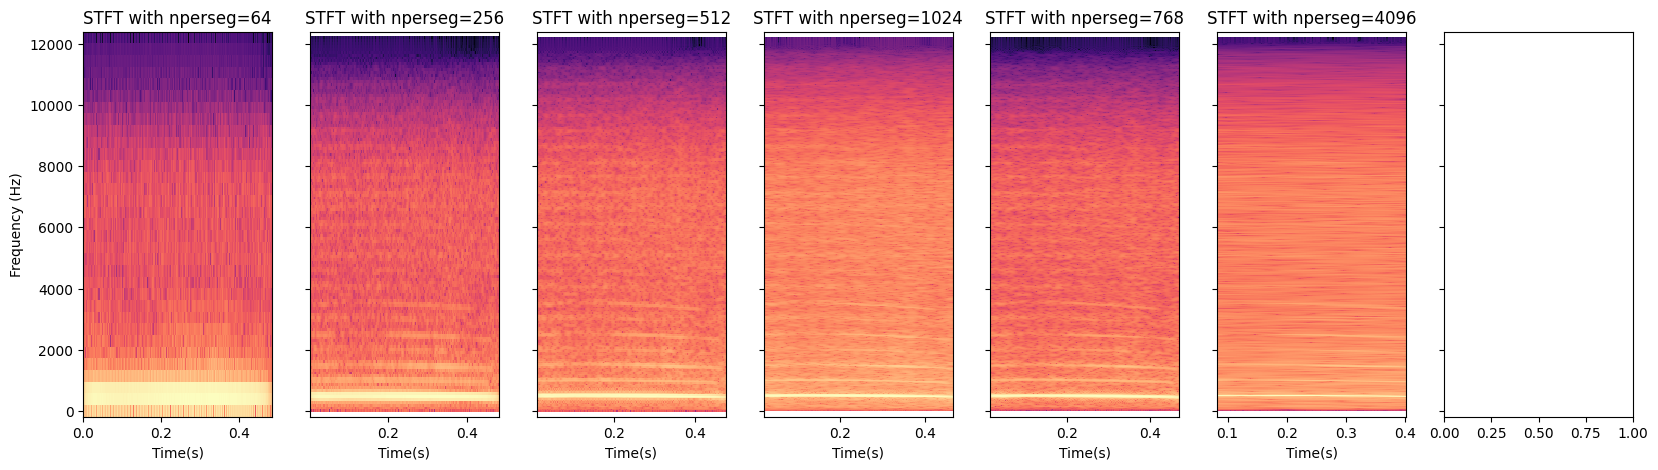

In [20]:
window_lengths(segmented,sr)

In [ ]:
from scipy.io.wavfile import write
write("example_audio4.wav", sr, audio_1)

In [12]:
event_file = os.listdir(f"{model_directory}/logs/train")[0]
event_file = f"{model_directory}/logs/train/{event_file}"

In [13]:
from tensorflow.python.summary.summary_iterator import summary_iterator
import struct
g_loss=[]
d_loss =[]
d_gp=[]
d_w_loss=[]
q_loss =[]
steps=[]
real_score = []
gen_score = []
for e in summary_iterator(event_file):    
    for v in e.summary.value:
        if v.tag == 'epoch_g_loss':            
            g_loss.append(struct.unpack('f', v.tensor.tensor_content)[0])
        
        elif v.tag == 'epoch_d_loss':            
            d_loss.append(struct.unpack('f', v.tensor.tensor_content)[0])
        
        elif v.tag == 'epoch_d_gp':            
            d_gp.append(struct.unpack('f', v.tensor.tensor_content)[0])

        elif v.tag == 'epoch_d_wass_loss':            
            d_w_loss.append(struct.unpack('f', v.tensor.tensor_content)[0])

        elif v.tag == 'epoch_q_loss':            
            q_loss.append(struct.unpack('f', v.tensor.tensor_content)[0])

        elif v.tag == 'epoch_real_socre':            
            real_score.append(struct.unpack('f', v.tensor.tensor_content)[0])
        
        elif v.tag == 'epoch_gen_score':            
            gen_score.append(struct.unpack('f', v.tensor.tensor_content)[0])

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [14]:
lr = specs["Learning Rate"]
specs_str = '\n'.join((
    r'Batch Size = %.f' % (specs["Batch Size"], ),
    r'Training Size = %.f' % (specs["Training Size"],),
    r'Discriminator Steps = %.f' % (specs["Discriminator Steps"], ),
    f"Learning Rate = {lr}"))
specs_str

'Batch Size = 64\nTraining Size = 3840\nDiscriminator Steps = 5\nLearning Rate = 1e-05'

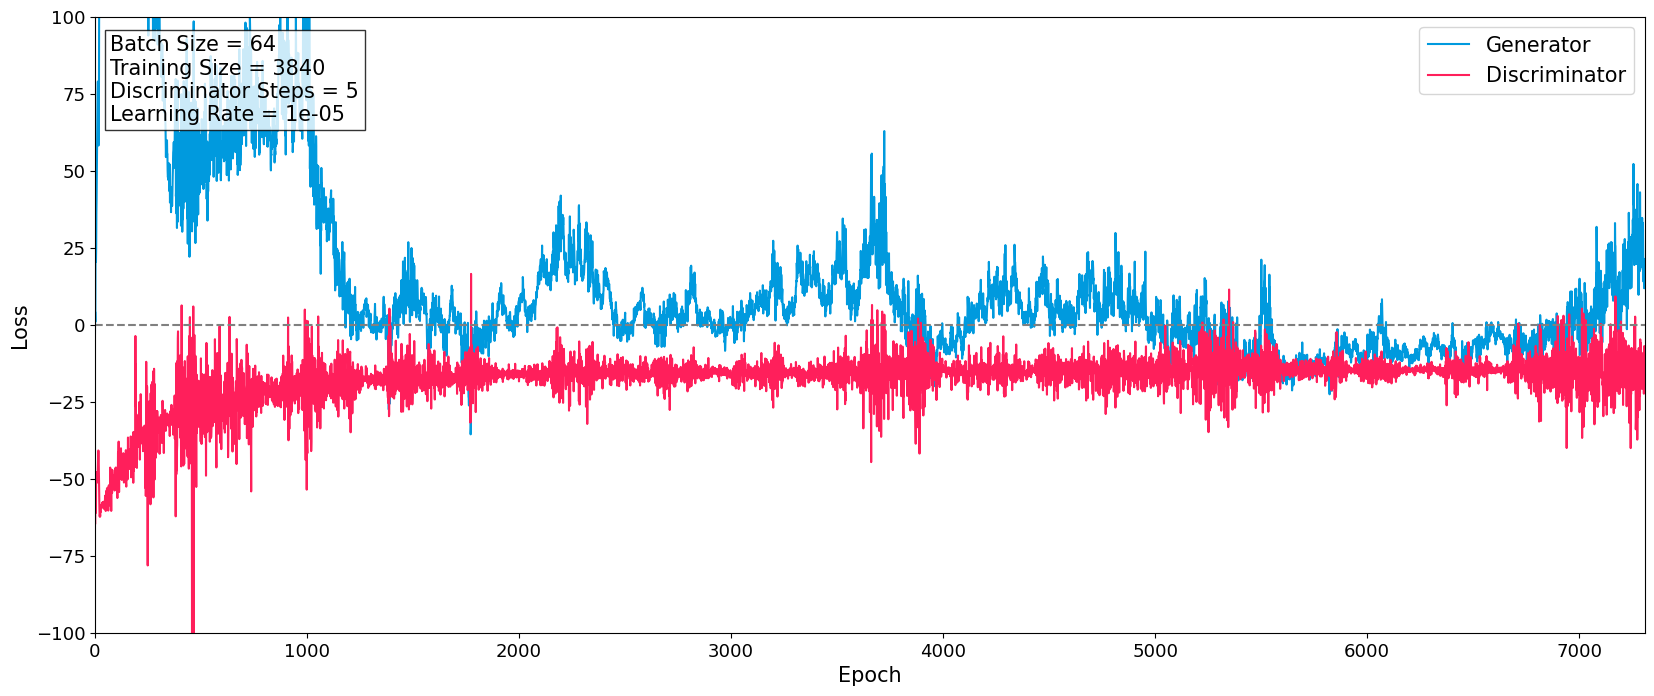

In [15]:
#plt.style.use('seaborn-pastel')
plt.figure(figsize=(20,8))
plt.plot(g_loss, label = "Generator", color = '#009ade')
plt.plot(d_loss, label = "Discriminator", color = '#ff1f5b')
plt.legend(fontsize= 15)
plt.xlim(0,len(g_loss))
plt.xlabel("Epoch", fontsize= 15)
plt.ylabel("Loss", fontsize= 15)
plt.xticks(fontsize= 13)
plt.yticks(fontsize= 13)
plt.axhline(y=0, color = "grey", linestyle = "dashed")
plt.ylim([-100,100])
#plt.xlim([0,1300])

plt.text(0.01, 0.97, specs_str, transform=plt.gca().transAxes, fontsize=15,
         verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.8))

fig_dir = f"{model_directory}/loss_graph.png"
plt.savefig(fig_dir, dpi= 300, bbox_inches = "tight", transparent = True)
plt.show()


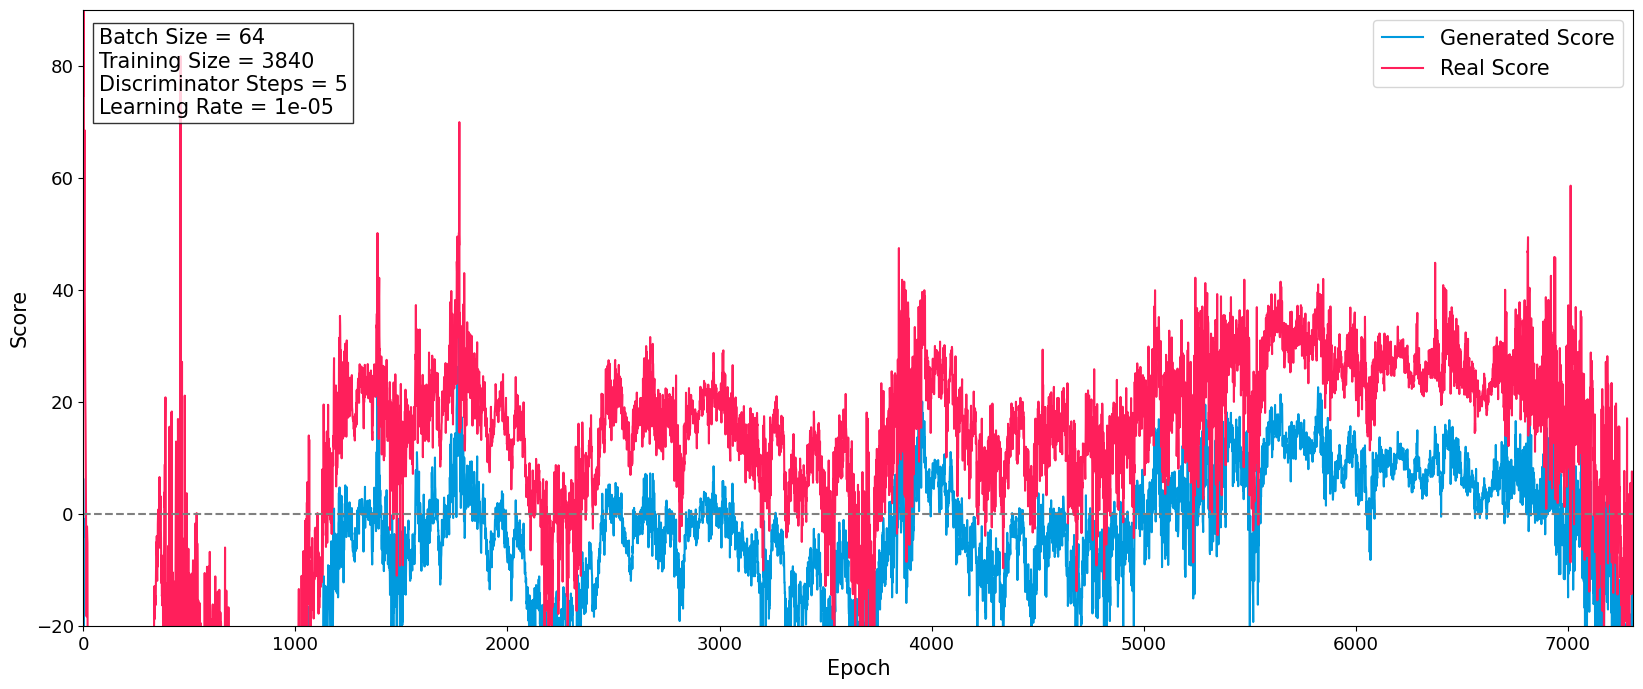

In [16]:
plt.figure(figsize=(20,8))
plt.plot(gen_score, label = "Generated Score", color = '#009ade')
plt.plot(real_score, label = "Real Score", color = '#ff1f5b')
plt.legend(fontsize= 15)
plt.xlim(0,len(gen_score))
plt.xlabel("Epoch", fontsize= 15)
plt.ylabel("Score", fontsize= 15)
plt.xticks(fontsize= 13)
plt.yticks(fontsize= 13)
plt.axhline(y=0, color = "grey", linestyle = "dashed")
plt.ylim([-20,90])
plt.text(0.01, 0.97, specs_str, transform=plt.gca().transAxes, fontsize=15,
         verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.8))

fig_dir = f"{model_directory}/scores_graph.png"
plt.savefig(fig_dir, dpi= 300, bbox_inches = "tight", transparent = True)
plt.show()

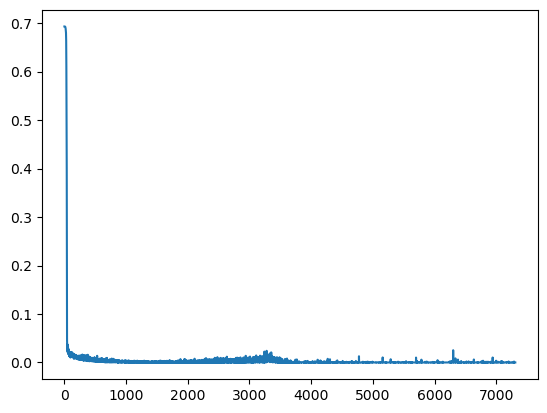

In [17]:
plt.plot(q_loss)
#plt.xlim([0,1300])
plt.show()


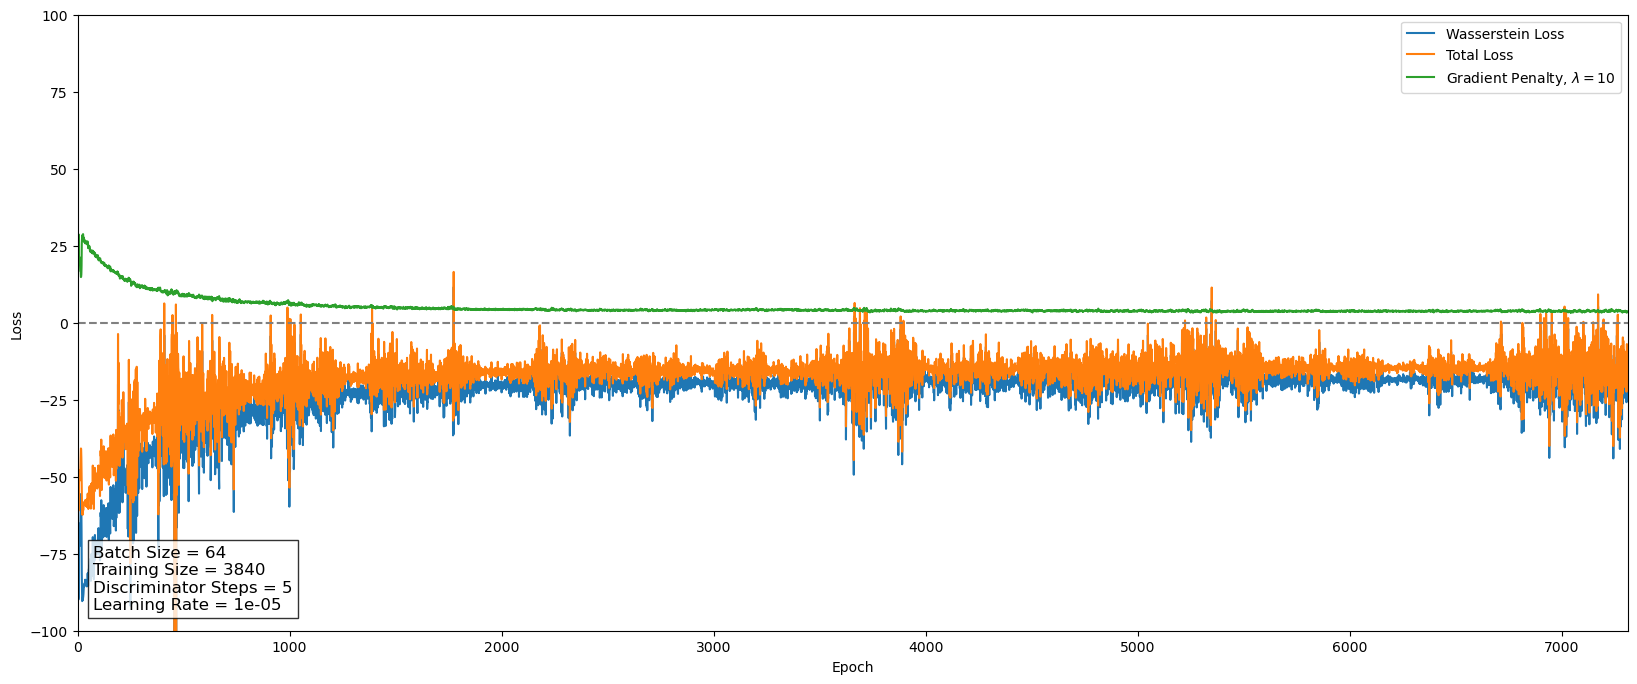

In [18]:
gp_weight = specs["GP Weight"]
plt.figure(figsize=(20,8))
plt.plot(d_w_loss, label = "Wasserstein Loss")

plt.plot(d_loss, label = "Total Loss")
plt.plot(np.array(d_gp)*gp_weight, label = f"Gradient Penalty, $\lambda = {gp_weight}$")
plt.legend()
plt.xlim(0,len(d_loss))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.axhline(y=0, color = "grey", linestyle = "dashed")
plt.ylim([-100,100])
plt.text(0.01, 0.03, specs_str, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.8))

fig_dir = f"{model_directory}/discriminator_loss_graph.png"
plt.savefig(fig_dir, dpi= 300, bbox_inches = "tight", transparent = True)
plt.show()